In [5]:
! pip install tensorflow matplotlib deepface scikit-learn ipynb


You should consider upgrading via the 'c:\users\shubham\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.

In [6]:
from deepface import DeepFace
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.models import load_model
import time
import numpy as np
import pandas as pd
import os

In [126]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)

In [127]:
model = load_model('weights/action.h5', compile=False)

In [128]:
img_height,img_width = 256, 256
classnames = np.array([i for i in range(1, 103)])

In [129]:
def findEuclideanDistance(source_representation, test_representation):
    if type(source_representation) == list:
        source_representation = np.array(source_representation)

    if type(test_representation) == list:
        test_representation = np.array(test_representation)

    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

In [130]:
def verify(filename1, filename2):
    image1=cv2.imread(filename1)
    image_resized1= cv2.resize(image1, (img_height,img_width))
    image1=np.expand_dims(image_resized1,axis=0)
    
    image2=cv2.imread(filename2)
    image_resized2= cv2.resize(image2, (img_height,img_width))
    image2=np.expand_dims(image_resized2,axis=0)
    
    pred1 = model.predict(image1)
    pred2 = model.predict(image2)
    
    distance = findEuclideanDistance(l2_normalize(pred1), l2_normalize(pred2))
    verified = False
    
    if distance < 0.75:
        verified = True
    
    return {'verified': verified, 'distance': distance}

In [31]:
tp,total = 0,0
incorrect = []
missed = []
filterwise_avg_dist = [0 for i in range(10)]

total_persons = 102
for person_no in range(1, total_persons+1):
    for filter_no in range(1, 11):
        baseline_img = "Dataset/Face Dataset/{}/{}.jpg".format(person_no, person_no)
        filtered_img = "Dataset/Face Dataset/{}/Filtered/{}_{}.jpg".format(person_no, person_no, filter_no)
        
        verified_dict = verify(baseline_img, filtered_img)
        distance = verified_dict['distance']
        
        if verified_dict['verified']:
            tp += 1
        
        filterwise_avg_dist[filter_no-1] += (distance)/total_persons
        
        total += 1

1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 207ms/step


1/1 [==============================] - 0s 209ms/step


1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 287ms/step


In [2]:
filterwise_avg_dist

[0.45854820778018335,
 0.5079767983284088,
 0.5802981363182577,
 0.332913964090931,
 0.22296686833186524,
 0.49471448107272153,
 0.1917113635912151,
 1.1796425625901008,
 0.6153962338947024,
 0.42738070820233404]

In [3]:
filter_names = ['Haircut_Filter_FaceApp', 'Child_Filter_FaceApp', 'Gender_Reverse_Filter_FaceApp',
               'Hipster_Beard_Style_Filter_FaceApp', 'Hair_Color_Blonde_Filter_FaceApp', 
               'Puppy_Filter_B612', 'So_Sad_Filter_B612', 'Hipster_Look_Filter_Snapchat',
                'Sparkling_Cartoon_Filter_Snapchat', 'Body_Mellow_Glow_Filter_Snapchat']

In [4]:
data = []
for i in range(len(filter_names)):
    data.append([filter_names[i], filterwise_avg_dist[i]])

In [9]:
columns = ['Filter Name', 'Average L2-Euclidean Distance']
df = pd.DataFrame(data = np.array(data), columns=columns)

In [10]:
df

,Filter Name,Average L2-Euclidean Distance
0,Haircut_Filter_FaceApp,0.45854820778018335
1,Child_Filter_FaceApp,0.5079767983284088
2,Gender_Reverse_Filter_FaceApp,0.5802981363182577
3,Hipster_Beard_Style_Filter_FaceApp,0.332913964090931
4,Hair_Color_Blonde_Filter_FaceApp,0.22296686833186524
5,Puppy_Filter_B612,0.49471448107272153
6,So_Sad_Filter_B612,0.1917113635912151
7,Hipster_Look_Filter_Snapchat,1.1796425625901008
8,Sparkling_Cartoon_Filter_Snapchat,0.6153962338947024
9,Body_Mellow_Glow_Filter_Snapchat,0.42738070820233404


In [26]:
df_dict = {'Filter Name': [], 'Average L2-Euclidean Distance': []}
df_dict['Filter Name'] = filter_names
df_dict['Average L2-Euclidean Distance'] = filterwise_avg_dist

In [27]:
import pickle
with open("filterwise_l2_distance.pkl", "wb") as f:
    pickle.dump(df_dict, f)

In [11]:
import os
import pickle
if os.path.exists("Results/Numerical Analysis/filterwise_l2_distance.pkl"):
    with open("Results/Numerical Analysis/filterwise_l2_distance.pkl", "rb") as f:
        df_dict = pickle.load(f)

In [12]:
import pandas as pd
df_filter = pd.DataFrame.from_dict(df_dict).dropna()
df_filter

,Filter Name,Average L2-Euclidean Distance
0,Haircut_Filter_FaceApp,0.458548
1,Child_Filter_FaceApp,0.507977
2,Gender_Reverse_Filter_FaceApp,0.580298
3,Hipster_Beard_Style_Filter_FaceApp,0.332914
4,Hair_Color_Blonde_Filter_FaceApp,0.222967
5,Puppy_Filter_B612,0.494714
6,So_Sad_Filter_B612,0.191711
7,Hipster_Look_Filter_Snapchat,1.179643
8,Sparkling_Cartoon_Filter_Snapchat,0.615396
9,Body_Mellow_Glow_Filter_Snapchat,0.427381


In [13]:
html = df_filter.to_html() 
with open('df_filter.html', 'w') as f:
    f.write(html)

In [131]:
import cv2
def commenting_on_the_usability_of_filters(filename):
    image=cv2.imread(filename)
    plt.imshow(image[:, :, ::-1])
    plt.title('Input Image')
    image_resized= cv2.resize(image, (img_height,img_width))
    image=np.expand_dims(image_resized,axis=0)
    
    pred_person_no = classnames[np.argmax(model.predict(image))]
    baseline_img = "Dataset/Face Dataset/{}/{}.jpg".format(pred_person_no, pred_person_no)
    filtered_img = filename
    
    verified_dict = verify(baseline_img, filtered_img)
    distance = verified_dict['distance']
    
    comments = ''
    if distance < 0.75:
        comments = 'The Filter DOES NOT produce significant distortion from the Baseline Image'
    else:
        comments = 'The Filter produces significant distortion from the Baseline Image'
        
    return {'Predicted Label': pred_person_no, 'Comments on Usability': comments}

In [132]:
data_dir = os.path.join("Dataset", "Image_Data")
person_no = 1
filter_no = 8
person_dir = os.path.join(data_dir, str(person_no)) 
filename = os.path.join(person_dir, "{}_Filtered_{}.jpg".format(person_no, filter_no))

{'Predicted Label': 55,
 'Comments on Usability': 'The Filter produces significant distortion from the Baseline Image'}

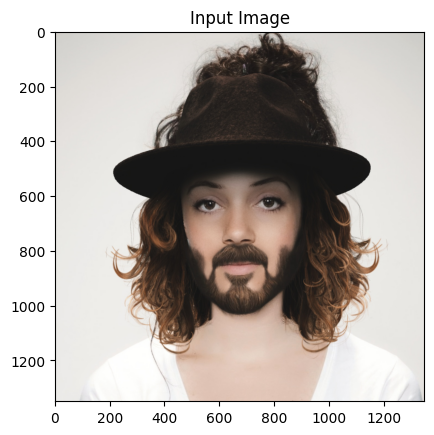

In [133]:
commenting_on_the_usability_of_filters(filename)

In [14]:
if os.path.exists("Results/Numerical Analysis/mispredictions_age_reduce.pkl"):
    with open("Results/Numerical Analysis/mispredictions_age_reduce.pkl", "rb") as f:
        deviation_reduce = pickle.load(f)

In [15]:
if os.path.exists("Results/Numerical Analysis/mispredictions_age_increase.pkl"):
    with open("Results/Numerical Analysis/mispredictions_age_increase.pkl", "rb") as f:
        deviation_increase = pickle.load(f)

In [16]:
if os.path.exists("Results/Numerical Analysis/avg_deviations.pkl"):
    with open("Results/Numerical Analysis/avg_deviations.pkl", "rb") as f:
        avg_deviations = pickle.load(f)

In [17]:
dev_red, dev_inc, avg_dev = [], [], []
for filter_no in range(1, 11):
    dev_red.append(deviation_reduce["Filter_{}".format(filter_no)]['avg'])
    dev_inc.append(deviation_increase["Filter_{}".format(filter_no)]['avg'])
    avg_dev.append(avg_deviations["Filter_{}".format(filter_no)])

In [18]:
df_age_analysis = df_filter[['Filter Name']]

In [19]:
df_age_analysis['Avg age Reduction (Yrs)'] = dev_red
df_age_analysis['Avg age Increment (Yrs)'] = dev_inc
df_age_analysis['Net Deviation (Yrs)'] = avg_dev

In [20]:
df_age_analysis

,Filter Name,Avg age Reduction (Yrs),Avg age Increment (Yrs),Net Deviation (Yrs)
0,Haircut_Filter_FaceApp,-2.062500,1.478261,-0.292120
1,Child_Filter_FaceApp,-3.371795,1.888889,-0.741453
2,Gender_Reverse_Filter_FaceApp,-3.492754,2.000000,-0.746377
3,Hipster_Beard_Style_Filter_FaceApp,-2.530303,1.812500,-0.358902
4,Hair_Color_Blonde_Filter_FaceApp,-2.369863,1.636364,-0.366750
5,Puppy_Filter_B612,-3.200000,1.800000,-0.700000
6,So_Sad_Filter_B612,-2.142857,1.733333,-0.204762
7,Hipster_Look_Filter_Snapchat,-5.774194,2.166667,-1.803763
8,Sparkling_Cartoon_Filter_Snapchat,-3.208333,3.153846,-0.027244
9,Body_Mellow_Glow_Filter_Snapchat,-2.716049,1.200000,-0.758025


In [21]:
html = df_age_analysis.to_html() 
with open('df_age_analysis.html', 'w') as f:
    f.write(html)

In [22]:
if os.path.exists("Results/Numerical Analysis/mispredictions_gender.pkl"):
    with open("Results/Numerical Analysis/mispredictions_gender.pkl", "rb") as f:
        mispredictions = pickle.load(f)

In [23]:
mispredictions

{'male': {'Filter_8': 5,
  'Filter_2': 4,
  'Filter_10': 1,
  'Filter_1': 1,
  'Filter_3': 1,
  'Filter_5': 1,
  'Filter_6': 1,
  'Filter_9': 1},
 'female': {'Filter_3': 3, 'Filter_6': 1, 'Filter_8': 2}}

In [24]:
mispredictions['no_of_males_classified_as_females'] = mispredictions.pop('male')
mispredictions['no_of_females_classified_as_males'] = mispredictions.pop('female')

In [25]:
mispredictions

{'no_of_males_classified_as_females': {'Filter_8': 5,
  'Filter_2': 4,
  'Filter_10': 1,
  'Filter_1': 1,
  'Filter_3': 1,
  'Filter_5': 1,
  'Filter_6': 1,
  'Filter_9': 1},
 'no_of_females_classified_as_males': {'Filter_3': 3,
  'Filter_6': 1,
  'Filter_8': 2}}

In [26]:
for filter_no in range(1, 11):
    filter_key = "Filter_{}".format(filter_no)
    if filter_key not in mispredictions['no_of_males_classified_as_females']:
        mispredictions['no_of_males_classified_as_females'][filter_key] = 0
    mispredictions['no_of_males_classified_as_females'][filter_names[filter_no - 1]] = mispredictions['no_of_males_classified_as_females'].pop(filter_key)
    if filter_key not in mispredictions['no_of_females_classified_as_males']:
        mispredictions['no_of_females_classified_as_males'][filter_key] = 0
    mispredictions['no_of_females_classified_as_males'][filter_names[filter_no - 1]] = mispredictions['no_of_females_classified_as_males'].pop(filter_key)

In [27]:
df_gender_mispredictions = pd.DataFrame.from_dict(mispredictions).dropna()
df_gender_mispredictions

,no_of_males_classified_as_females,no_of_females_classified_as_males
Haircut_Filter_FaceApp,1,0
Child_Filter_FaceApp,4,0
Gender_Reverse_Filter_FaceApp,1,3
Hipster_Beard_Style_Filter_FaceApp,0,0
Hair_Color_Blonde_Filter_FaceApp,1,0
Puppy_Filter_B612,1,1
So_Sad_Filter_B612,0,0
Hipster_Look_Filter_Snapchat,5,2
Sparkling_Cartoon_Filter_Snapchat,1,0
Body_Mellow_Glow_Filter_Snapchat,1,0


In [28]:
html = df_gender_mispredictions.to_html() 
with open('df_gender_mispredictions.html', 'w') as f:
    f.write(html)

In [59]:
eth_model = load_model('weights/action_eth.h5')

In [29]:
if os.path.exists("Results/Numerical Analysis/mispredictions_eth.pkl"):
    with open("Results/Numerical Analysis/mispredictions_eth.pkl", "rb") as f:
        mispredictions_eth = pickle.load(f)

In [30]:
mispredictions_eth

{'black': {'east_asian': {'Filter_4': 3,
   'Filter_10': 2,
   'Filter_2': 1,
   'Filter_6': 2,
   'Filter_9': 2,
   'Filter_8': 1,
   'Filter_1': 1,
   'Filter_7': 1},
  'west_asian': {'Filter_1': 3,
   'Filter_2': 8,
   'Filter_3': 1,
   'Filter_6': 7,
   'Filter_7': 5,
   'Filter_10': 4,
   'Filter_4': 5,
   'Filter_5': 2,
   'Filter_9': 2},
  'white': {'Filter_8': 11,
   'Filter_9': 2,
   'Filter_1': 3,
   'Filter_5': 2,
   'Filter_10': 1,
   'Filter_4': 1,
   'Filter_2': 1,
   'Filter_3': 1,
   'Filter_6': 1}},
 'east_asian': {'black': {},
  'west_asian': {},
  'white': {'Filter_4': 2,
   'Filter_8': 9,
   'Filter_3': 1,
   'Filter_5': 1,
   'Filter_1': 1}},
 'west_asian': {'east_asian': {'Filter_2': 1,
   'Filter_7': 1,
   'Filter_8': 1,
   'Filter_9': 1},
  'black': {},
  'white': {'Filter_1': 2,
   'Filter_8': 9,
   'Filter_9': 5,
   'Filter_10': 5,
   'Filter_3': 3,
   'Filter_4': 2,
   'Filter_5': 3,
   'Filter_2': 2,
   'Filter_6': 1,
   'Filter_7': 1}},
 'white': {'east_asi

In [31]:
for k1 in mispredictions_eth.keys():
    for k2 in mispredictions_eth[k1].keys():
        for filter_no in range(1, 11):
            filter_key = "Filter_{}".format(filter_no)
            if filter_key not in mispredictions_eth[k1][k2].keys():
                mispredictions_eth[k1][k2][filter_key] = 0
            mispredictions_eth[k1][k2][filter_names[filter_no - 1]] = mispredictions_eth[k1][k2].pop(filter_key)

In [32]:
mispredictions_eth

{'black': {'east_asian': {'Haircut_Filter_FaceApp': 1,
   'Child_Filter_FaceApp': 1,
   'Gender_Reverse_Filter_FaceApp': 0,
   'Hipster_Beard_Style_Filter_FaceApp': 3,
   'Hair_Color_Blonde_Filter_FaceApp': 0,
   'Puppy_Filter_B612': 2,
   'So_Sad_Filter_B612': 1,
   'Hipster_Look_Filter_Snapchat': 1,
   'Sparkling_Cartoon_Filter_Snapchat': 2,
   'Body_Mellow_Glow_Filter_Snapchat': 2},
  'west_asian': {'Haircut_Filter_FaceApp': 3,
   'Child_Filter_FaceApp': 8,
   'Gender_Reverse_Filter_FaceApp': 1,
   'Hipster_Beard_Style_Filter_FaceApp': 5,
   'Hair_Color_Blonde_Filter_FaceApp': 2,
   'Puppy_Filter_B612': 7,
   'So_Sad_Filter_B612': 5,
   'Hipster_Look_Filter_Snapchat': 0,
   'Sparkling_Cartoon_Filter_Snapchat': 2,
   'Body_Mellow_Glow_Filter_Snapchat': 4},
  'white': {'Haircut_Filter_FaceApp': 3,
   'Child_Filter_FaceApp': 1,
   'Gender_Reverse_Filter_FaceApp': 1,
   'Hipster_Beard_Style_Filter_FaceApp': 1,
   'Hair_Color_Blonde_Filter_FaceApp': 2,
   'Puppy_Filter_B612': 1,
   'So_S

In [33]:
df_eth_mis = {}
ethnicities = ['black', 'east_asian', 'west_asian', 'white']

for eth in ethnicities:
    df_eth_mis[eth] = {filter_name: 0 for filter_name in filter_names}

In [34]:
for filter_name in filter_names:
    for k1 in mispredictions_eth.keys():
        for k2 in mispredictions_eth[k1].keys():
            df_eth_mis[k2][filter_name] += mispredictions_eth[k1][k2].get(filter_name, 0)

In [35]:
df_eth_mis

{'black': {'Haircut_Filter_FaceApp': 0,
  'Child_Filter_FaceApp': 0,
  'Gender_Reverse_Filter_FaceApp': 0,
  'Hipster_Beard_Style_Filter_FaceApp': 0,
  'Hair_Color_Blonde_Filter_FaceApp': 0,
  'Puppy_Filter_B612': 0,
  'So_Sad_Filter_B612': 0,
  'Hipster_Look_Filter_Snapchat': 0,
  'Sparkling_Cartoon_Filter_Snapchat': 0,
  'Body_Mellow_Glow_Filter_Snapchat': 0},
 'east_asian': {'Haircut_Filter_FaceApp': 3,
  'Child_Filter_FaceApp': 10,
  'Gender_Reverse_Filter_FaceApp': 0,
  'Hipster_Beard_Style_Filter_FaceApp': 8,
  'Hair_Color_Blonde_Filter_FaceApp': 3,
  'Puppy_Filter_B612': 15,
  'So_Sad_Filter_B612': 6,
  'Hipster_Look_Filter_Snapchat': 3,
  'Sparkling_Cartoon_Filter_Snapchat': 5,
  'Body_Mellow_Glow_Filter_Snapchat': 3},
 'west_asian': {'Haircut_Filter_FaceApp': 6,
  'Child_Filter_FaceApp': 8,
  'Gender_Reverse_Filter_FaceApp': 2,
  'Hipster_Beard_Style_Filter_FaceApp': 6,
  'Hair_Color_Blonde_Filter_FaceApp': 3,
  'Puppy_Filter_B612': 7,
  'So_Sad_Filter_B612': 7,
  'Hipster_Loo

In [36]:
df_eth_mispredictions = pd.DataFrame.from_dict(df_eth_mis).dropna()
df_eth_mispredictions

,black,east_asian,west_asian,white
Haircut_Filter_FaceApp,0,3,6,6
Child_Filter_FaceApp,0,10,8,3
Gender_Reverse_Filter_FaceApp,0,0,2,5
Hipster_Beard_Style_Filter_FaceApp,0,8,6,5
Hair_Color_Blonde_Filter_FaceApp,0,3,3,6
Puppy_Filter_B612,0,15,7,2
So_Sad_Filter_B612,0,6,7,1
Hipster_Look_Filter_Snapchat,0,3,0,29
Sparkling_Cartoon_Filter_Snapchat,0,5,2,7
Body_Mellow_Glow_Filter_Snapchat,0,3,4,6


In [37]:
html = df_eth_mispredictions.to_html() 
with open('df_eth_mispredictions.html', 'w') as f:
    f.write(html)

In [74]:
import os
import pickle
if os.path.exists("Results/Numerical Analysis/gender_dict.pkl"):
    with open("Results/Numerical Analysis/gender_dict.pkl", "rb") as f:
        df_gender = pickle.load(f)

In [75]:
df_gender

,face_id,filter_no,actual_gender,predicted_gender_baseline,predicted_gender_filtered
0,1,1,female,female,female
1,1,2,female,female,female
2,1,3,female,female,female
3,1,4,female,female,female
4,1,5,female,female,female
...,...,...,...,...,...
1015,173,6,male,male,male
1016,173,7,male,male,male
1017,173,8,male,male,male
1018,173,9,male,male,male


In [87]:
filter_gender_list = [{'actual_gender':[], 'predicted_gender':[]} for filter_no in range(11)]
for filter_no in range(1, 11):
    filter_gender_list[filter_no]['actual_gender'] = df_gender[df_gender['filter_no']==filter_no]['actual_gender'].to_list()
    filter_gender_list[filter_no]['predicted_gender'] = df_gender[df_gender['filter_no']==filter_no]['predicted_gender_filtered'].to_list()

In [89]:
genders = ['female', 'male']

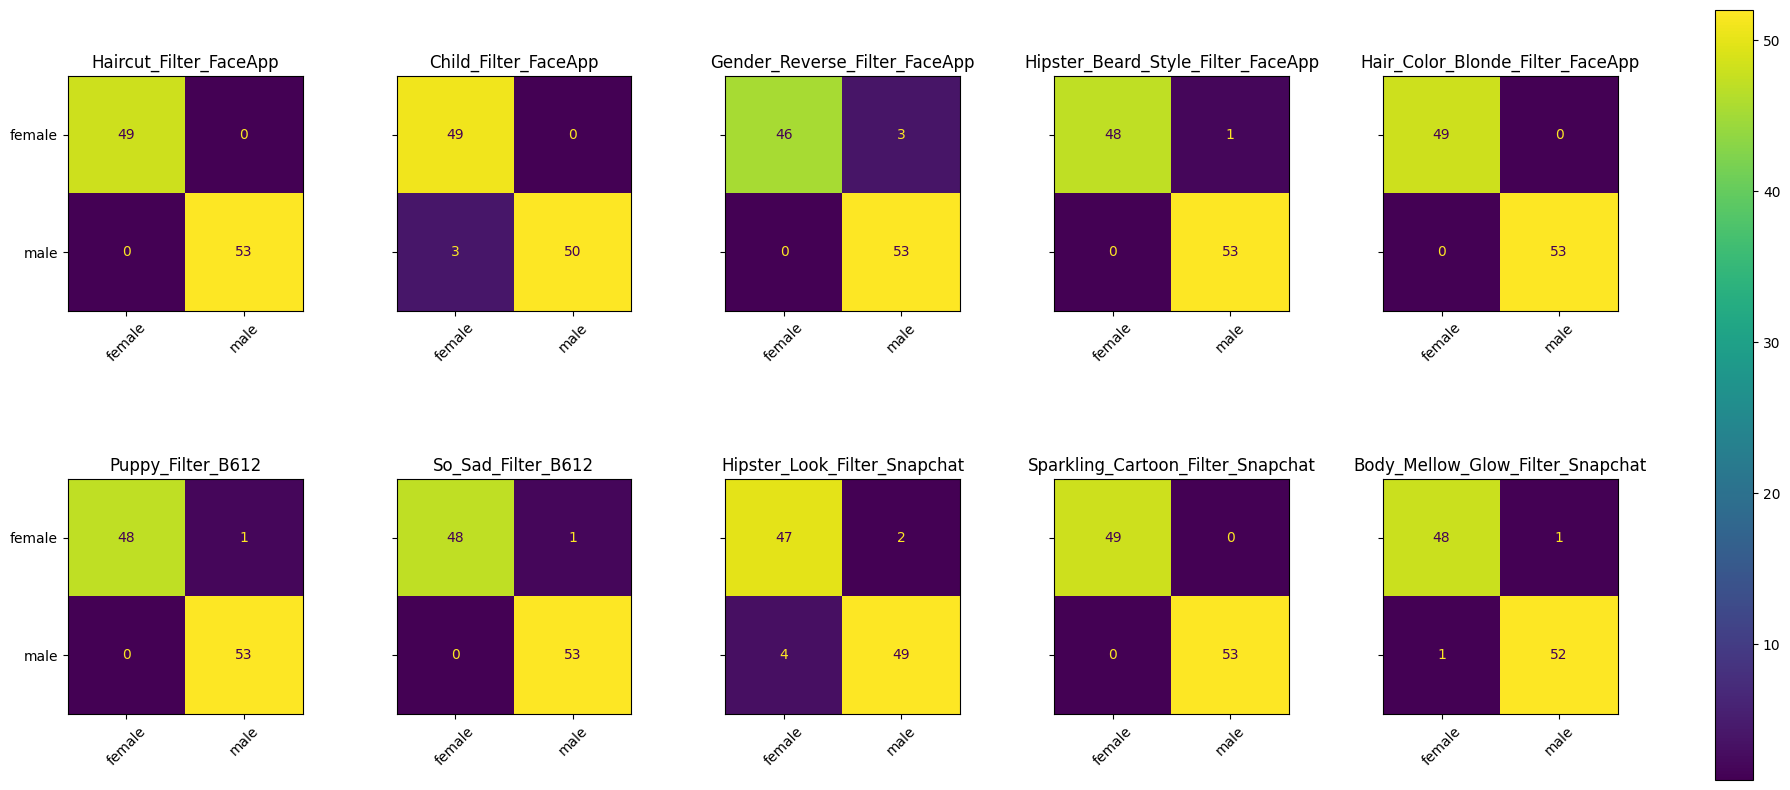

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
f, axes = plt.subplots(2, 5, figsize=(25, 10), sharey='row')
for filter_no in range(1, 11):
    y_true = filter_gender_list[filter_no]['actual_gender']
    y_pred = filter_gender_list[filter_no]['predicted_gender']
    cm = confusion_matrix(y_true, y_pred, labels=genders)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genders)
    disp.plot(ax=axes[int((filter_no -1)/5)][int((filter_no-1)%5)], xticks_rotation=45)
    disp.ax_.set_title(filter_names[filter_no-1])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.savefig('Results/Visual Analysis/conf_mat_gender.pdf', bbox_inches='tight', dpi=700)
plt.show()

In [116]:
import os
import pickle
if os.path.exists("Results/Numerical Analysis/eth_dict.pkl"):
    with open("Results/Numerical Analysis/eth_dict.pkl", "rb") as f:
        df_eth = pickle.load(f)

In [117]:
df_eth

,face_id,filter_no,actual_ethnicity,predicted_ethnicity_baseline,predicted_ethnicity_filtered
0,1,1,white,white,white
1,1,2,white,white,white
2,1,3,white,white,white
3,1,4,white,white,white
4,1,5,white,white,white
...,...,...,...,...,...
1015,173,6,white,white,white
1016,173,7,white,white,white
1017,173,8,white,white,white
1018,173,9,white,white,white


In [118]:
filter_eth_list = [{'actual_ethnicity':[], 'predicted_ethnicity':[]} for filter_no in range(11)]
for filter_no in range(1, 11):
    filter_eth_list[filter_no]['actual_ethnicity'] = df_eth[df_eth['filter_no']==filter_no]['actual_ethnicity'].to_list()
    filter_eth_list[filter_no]['predicted_ethnicity'] = df_eth[df_eth['filter_no']==filter_no]['predicted_ethnicity_filtered'].to_list()

In [119]:
eths = ['east_asian', 'west_asian', 'white', 'black']

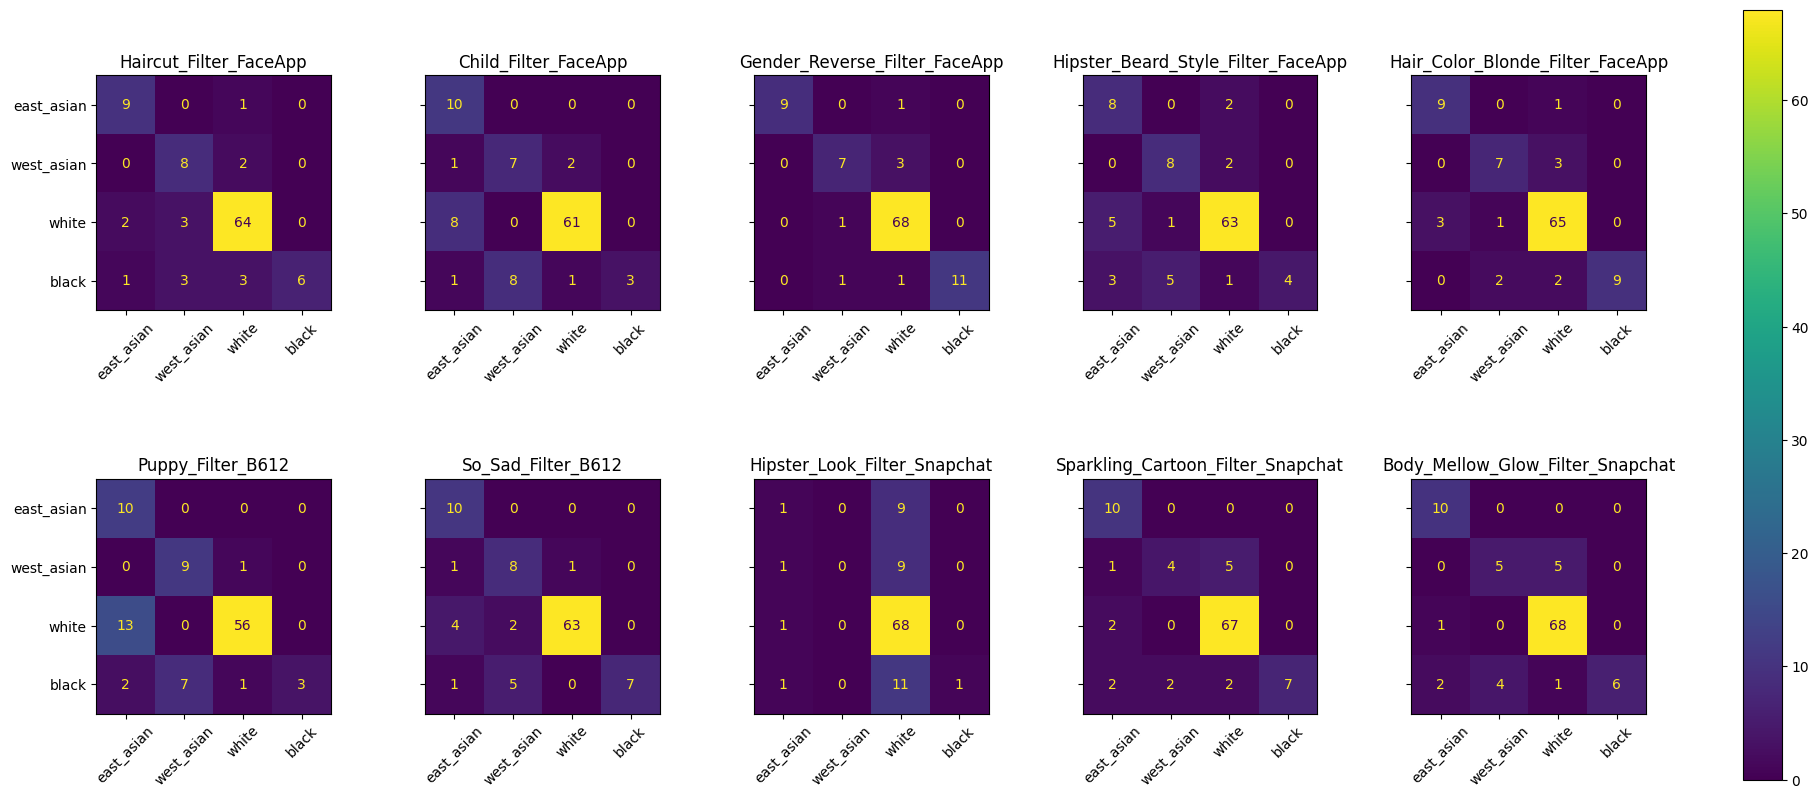

In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
f, axes = plt.subplots(2, 5, figsize=(25, 10), sharey='row')
for filter_no in range(1, 11):
    y_true = filter_eth_list[filter_no]['actual_ethnicity']
    y_pred = filter_eth_list[filter_no]['predicted_ethnicity']
    cm = confusion_matrix(y_true, y_pred, labels=eths)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eths)
    disp.plot(ax=axes[int((filter_no -1)/5)][int((filter_no-1)%5)], xticks_rotation=45)
    disp.ax_.set_title(filter_names[filter_no-1])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.savefig('Results/Visual Analysis/conf_mat_eth.pdf', bbox_inches='tight', dpi=700)
plt.show()